# Problem Statement: 

Our objective is to develop a predictive model that can predict whether or not a movie is a <i>Drama</i>. In order to do so we need to use the textual features of the movie stories and creat your predictive models. There are totally three different files in this project.

<ol>
    <li><b>movie_story_student_file.csv</b>: This file contains the movie stories that should be used by students for model development.</li>
    <li><b>movie_story_evaluation_file.csv</b>: This file should NOT be used for model development purposes. We should only use this file after developing their predictive models and selecting their best final model. Then need to use their best predictive model and predict whether or not the movies in <b>movie story evaluation file.csv</b> are Drama.</li>
    <li><b>movies.csv</b>: This file contain the movie genres.</li>
</ol>

# Data Structuring 

In [1]:
#Importing required libraries
import re
%matplotlib inline
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from tqdm import tqdm
import matplotlib as mpl
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading in data which has movieID, story(review)

movies = pd.read_csv("movie_story_student_file.csv", encoding='ISO-8859-1')
movies

,movie_id,story
0,131072,A girl who always tends to fall in love with t...
1,196609,"Bigfoot has come to the town of Ellwood City, ..."
2,131074,"At an altitude of 18,000 feet, Alaska\'s Mount..."
3,196611,"In her first special since 2003, Ellen revisit..."
4,196613,Mike and Sulley are back at Monsters Universit...
...,...,...
19995,56801,The iconic creatures from two of the scariest ...
19996,122337,When a bored-with-life English teacher meets a...
19997,187875,Herbert Blount is a crowdfunding contributor f...
19998,187873,REAL BOY is the coming-of-age story of Bennett...


In [3]:
#reading in data which has movieID, Title, and accompanying genres
genre = pd.read_csv("movies.csv")
genre

,movieId,title,genres
0,27509,Carolina (2005),Comedy|Romance
1,27618,"Sound of Thunder, A (2005)",Action|Adventure|Drama|Sci-Fi|Thriller
2,27788,"Jacket, The (2005)",Drama|Mystery|Sci-Fi|Thriller
3,27821,"Interpreter, The (2005)",Drama|Thriller
4,27839,"Ring Two, The (2005)",Drama|Horror|Mystery|Thriller
...,...,...,...
23493,209051,Jeff Garlin: Our Man in Chicago (2019),(no genres listed)
23494,209085,The Mistletoe Secret (2019),Romance
23495,209133,The Riot and the Dance (2018),(no genres listed)
23496,209157,We (2018),Drama


In [4]:
#merging training files into 'main_dataset' variable
#removed movieid & title
main_dataset = pd.merge(movies,genre,left_on="movie_id", right_on = "movieId").drop(columns=['movieId', 'title', 'movie_id'])
main_dataset = main_dataset.rename(columns={"genres":"DramaGenre"})   
main_dataset.head()

,story,DramaGenre
0,A girl who always tends to fall in love with t...,Comedy
1,"Bigfoot has come to the town of Ellwood City, ...",Comedy|Horror
2,"At an altitude of 18,000 feet, Alaska\'s Mount...",Documentary
3,"In her first special since 2003, Ellen revisit...",Comedy
4,Mike and Sulley are back at Monsters Universit...,Animation|Children|Comedy|Fantasy


In [5]:
# Mapping genre column to that shows 1 if movie is a 'drama' and 0 if 'not a drama'

main_dataset.DramaGenre[main_dataset.DramaGenre.str.contains("Drama")] = 1
main_dataset.DramaGenre[main_dataset.DramaGenre!=1]=0
main_dataset.head(15)

,story,DramaGenre
0,A girl who always tends to fall in love with t...,0
1,"Bigfoot has come to the town of Ellwood City, ...",0
2,"At an altitude of 18,000 feet, Alaska\'s Mount...",0
3,"In her first special since 2003, Ellen revisit...",0
4,Mike and Sulley are back at Monsters Universit...,0
5,When Lady Tremaine steals the Fairy Godmother\...,0
6,"Film that mixes live action and animation, fro...",0
7,"When a beautiful ballerina dancer, Adriana Men...",0
8,Jonas is 18-years-old and has had to repeat se...,0
9,"When ex-soldier turned mercenary, John Gold, l...",0


In [7]:
main_dataset['DramaGenre'].value_counts()

0    11588
1     8412
Name: DramaGenre, dtype: int64

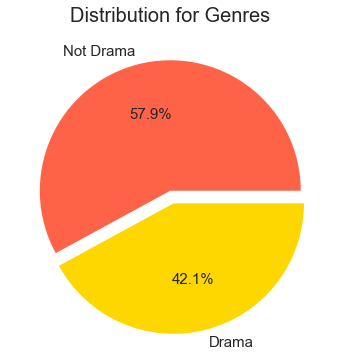

In [8]:
# Visualizing distribution of Genres 

main_dataset.groupby('DramaGenre').size().plot(kind='pie', labels=['Not Drama', 'Drama'], colors=['tomato', 'gold'], autopct='%1.1f%%',
                                   figsize=(6,6), explode=[0,0.1], textprops={'fontsize': 15})


plt.ylabel('')
plt.title("Distribution for Genres", fontsize=20)
plt.show()

# Data Preprocessing

In [6]:
#implementing stemming
#removing stopwords

stemmer = PorterStemmer()
stop = stopwords.words('english') 

for item,text in tqdm(enumerate(main_dataset.story)): 
    
    text = re.sub(r'\\x[0-9a-f]{2}', "", text) #removing the 'x-99' etc text
    text = text.lower() #lowering text
    text = text.replace("-", " ") #seperating words connected by hyphen
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text) #removing special symbols
    tokens = word_tokenize(text) #tokenizing text
    tokens = [token for token in tokens if token not in stop] #removing stop words
    tokens = [stemmer.stem(token) for token in tokens] #stemming each token
    tokens = [token for token in tokens if token.isalpha() and len(token)>2] #removing all of the tokens that are not words and a length of less than two
    main_dataset.story[item] =  " ".join(word for word in tokens) #joined tokens
   

20000it [00:51, 391.45it/s]


In [7]:
#splitting dataset

y = main_dataset.DramaGenre.astype('int') #defining our target variable

cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(main_dataset.story, y, 
                                                    test_size=0.2, random_state=0, stratify=y)

### Baseline Model: Dummy Classifier

In [19]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train,y_train)
print('Baseline Dummy Classifier Accuracy Score',dummy_clf.score(X_test,y_test))

Baseline Dummy Classifier Accuracy Score 0.51875


### Method 1: Bag of Words

In [29]:
#implement countvectorizer

vect_BOW = CountVectorizer(ngram_range=(1,2))
X_train_BoW = vect_BOW.fit_transform(X_train)
X_test_BoW = vect_BOW.transform(X_test)
X_BoW = vect_BOW.transform(main_dataset.story)

In [30]:
print(X_train_BoW.shape, X_test_BoW.shape)

(16000, 385238) (4000, 385238)


### Method 2: TF-IDF

In [31]:
# implementing TF-IDF

vect_TFIDF = TfidfVectorizer(ngram_range=(1,2))
X_train_TFIDF = vect_TFIDF.fit_transform(X_train)
X_test_TFIDF = vect_TFIDF.transform(X_test)

In [32]:
print(X_train_TFIDF.shape, X_test_TFIDF.shape)

(16000, 385238) (4000, 385238)


### Method 3: Topic Modelling

In [33]:
lda = LatentDirichletAllocation(n_components=25, learning_method="batch",
                                max_iter=25, random_state=0)
X_train_Lda = lda.fit_transform(X_train_BoW)
X_test_Lda = lda.transform(X_test_BoW)

In [34]:
print(X_train_Lda.shape, X_test_Lda.shape)

(16000, 25) (4000, 25)


### Method 4: Word Embedding

In [26]:
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:10, 39196.36it/s]


In [27]:
embeddings = []
for review in tqdm(X_train):
    base_embedding = np.zeros((50,))
    word_count = 0
    for token in word_tokenize(review):
        token = token.lower()
        if token in stopwords.words('english'):
            continue
        try:
            base_embedding += embeddings_index[token]
            word_count +=1
        except:
            continue
    base_embedding = base_embedding/word_count
    embeddings.append(base_embedding)
    
X_train_WE = np.array(embeddings)
X_train_WE[np.isnan(X_train_WE)] = 0
X_train_WE.shape

100%|████████████████████████████████████████████████████████████████████████████| 16000/16000 [02:44<00:00, 97.35it/s]


(16000, 50)

In [28]:
embeddings = []
for review in tqdm(X_test):
    base_embedding = np.zeros((50,))
    word_count = 0
    for token in word_tokenize(review):
        token = token.lower()
        if token in stopwords.words('english'):
            continue
        try:
            base_embedding += embeddings_index[token]
            word_count +=1
        except:
            continue
    base_embedding = base_embedding/word_count
    embeddings.append(base_embedding)
    
X_test_WE = np.array(embeddings)
X_test_WE[np.isnan(X_test_WE)] = 0
X_test_WE.shape

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:40<00:00, 99.79it/s]


(4000, 50)

# Visualizations

#### Term Frequency Visualization

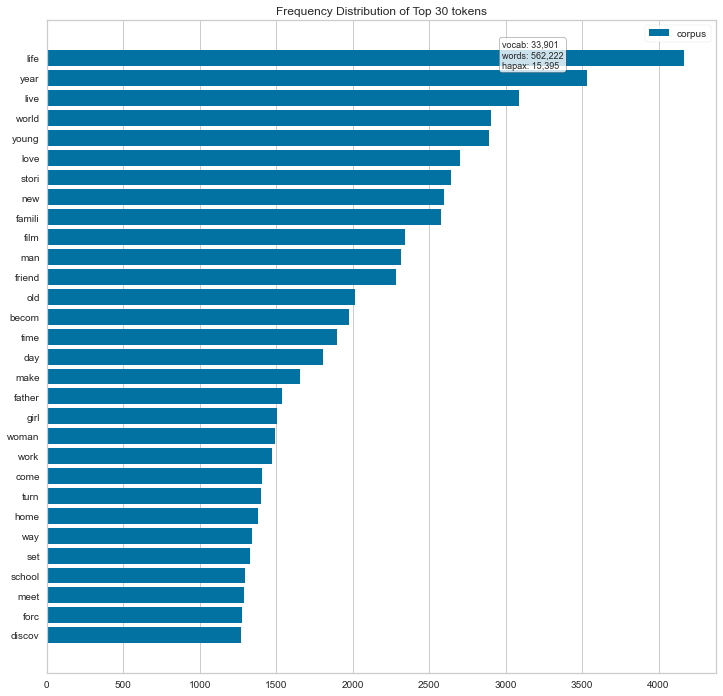

<AxesSubplot:title={'center':'Frequency Distribution of Top 30 tokens'}>

In [47]:
# Find the Document Term Frequency Matrix 
vect = CountVectorizer(stop_words='english')
X = vect.fit_transform(main_dataset.story)

# Get all features (tokens)
features = vect.get_feature_names_out()

# Use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(12,12))
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(X)
visualizer.poof()

In [48]:
lda = LatentDirichletAllocation(n_components=5, learning_method="batch",
                                max_iter=25, random_state=0) 
document_topics = lda.fit_transform(X)

In [49]:
vect.get_feature_names_out

<bound method CountVectorizer.get_feature_names_out of CountVectorizer(stop_words='english')>

In [50]:
# Set n to your desired number of tokens 
n = 8
# Get features (tokens) from CountVectorizer
feature_names = np.array(vect.get_feature_names_out())
# Find top n tokens
topics = dict()
for idx, component in enumerate(lda.components_): 
    top_n_indices = component.argsort()[:-(n + 1): -1] 
    topic_tokens = [feature_names[i] for i in top_n_indices] 
    topics[idx] = topic_tokens

topics

{0: ['film',
  'stori',
  'documentari',
  'life',
  'music',
  'world',
  'featur',
  'new'],
 1: ['friend', 'game', 'new', 'time', 'set', 'come', 'becom', 'island'],
 2: ['murder', 'young', 'school', 'polic', 'kill', 'man', 'mysteri', 'becom'],
 3: ['life', 'love', 'year', 'live', 'famili', 'young', 'old', 'friend'],
 4: ['world', 'war', 'human', 'stori', 'team', 'power', 'group', 'forc']}

In [51]:
topic_0 = np.argsort(document_topics[:, 0])[::-1]
# print the five documents where the topic is most important 
for index in topic_0[:5]:
    # pshow first two sentences
    print(main_dataset.story[index],"\n------------\n")

komedi rodich dtech chce navzat nejlep tradic esk filmov komedi vtipn dialog vjimen hereck vkoni humor spojujc divki nap generacemi pbh filmu vychz zdnliv banln situac syn david novotn jde prochzku svm otcem josef somr syn zral tyictnk ije spokojen svou ptelkyn otci sedmdest bval vdec biolog klasick intelektul dobrm slova smyslu zdnliv jedin tyto dva mue spojuj jdou jednou msc spolen projt prahou nicmn jsou svzni poutem tyiceti let spolenho ivota brilantn vedenm dialogu ped nmi odkrvaj djini dvactho stolet vechni absurd spojen odhaluj nejhlub msta lidskch vztah odtajuj star resti trpen radosti scn objev vnuk kterm syn neml dvacet let ani tuen nkter chybi opakuj znovu znovu 
------------

tyi zbrusu nov pohdki pro chytr dti chytr dospl oblben knihi jana wericha klasik animovanho filmu betislav pojar natoil slavn pbh malikho paleka pln zvrat dobrodrustv jeho cest svta zase dom pod vedenm aurela klimta oij navzjem podobn hrbat brati hrbi damaku pinej atmosfru exotickho blzkho vchodu pestr

In [52]:
topic_0 = np.argsort(document_topics[:, 1])[::-1]
# print the five documents where the topic is most important 
for index in topic_0[:5]:
    # pshow first two sentences
    print(main_dataset.story[index],"\n------------\n")

esra didem zeynep yakn arkada olmalarna ramen birbirinden farkl hayatlar srdren farkl karakterler sahip kiidir sessiz sakin olan esra deli dolu olan didem domin karakter sahip olan zeynep arkadatan istikrarl olarak ilikisini srdrebilmi olan zeynepin hem esrann hem didemin hayatnda deiik sprizler neden olacaktr stemedii bir ite yllardr alan esra bir cesaret rnei gstererek hayatn deitirmey karar verir bunun iin ilk adm atar iinden istifa eder giden ilikisini sona erdirir uzun aramalarndan sonra zar zor bulduu reklam ajansna almaya balayana esray bir srpriz bekliyordur 
------------

disney channel product juli sherman wolf screenplay adapt popular novel avalon high meg cabot elain elli harrison move minnesota annapoli maryland parent take year long sabbat continu mediev studi nearbi new high school avalon high seem like typic high school stereotyp student lanc jock jennif cheerlead marco bad boydesperado senior class presid quarterback around good guy everyon avalon high appear even elli

In [53]:
# Let's increase the number of topics to 20 
n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, learning_method="batch",
                                max_iter=25, random_state=0) 
document_topics = lda.fit_transform(X)

# Sort the tokens and get top 2 tokens in each topic
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
topic_names = ["{:>2} ".format(i) + " ".join(words) 
               for i, words in enumerate(feature_names[sorting[:, :2]])] 

In [54]:
topic_names

[' 0 star porn',
 ' 1 ben game',
 ' 2 murder polic',
 ' 3 life love',
 ' 4 team world',
 ' 5 school time',
 ' 6 mysteri friend',
 ' 7 isra nazi',
 ' 8 music film',
 ' 9 world scientist',
 '10 plan friend',
 '11 year work',
 '12 forc war',
 '13 prison death',
 '14 film movi',
 '15 stori film',
 '16 world life',
 '17 food life',
 '18 friend school',
 '19 love stori']

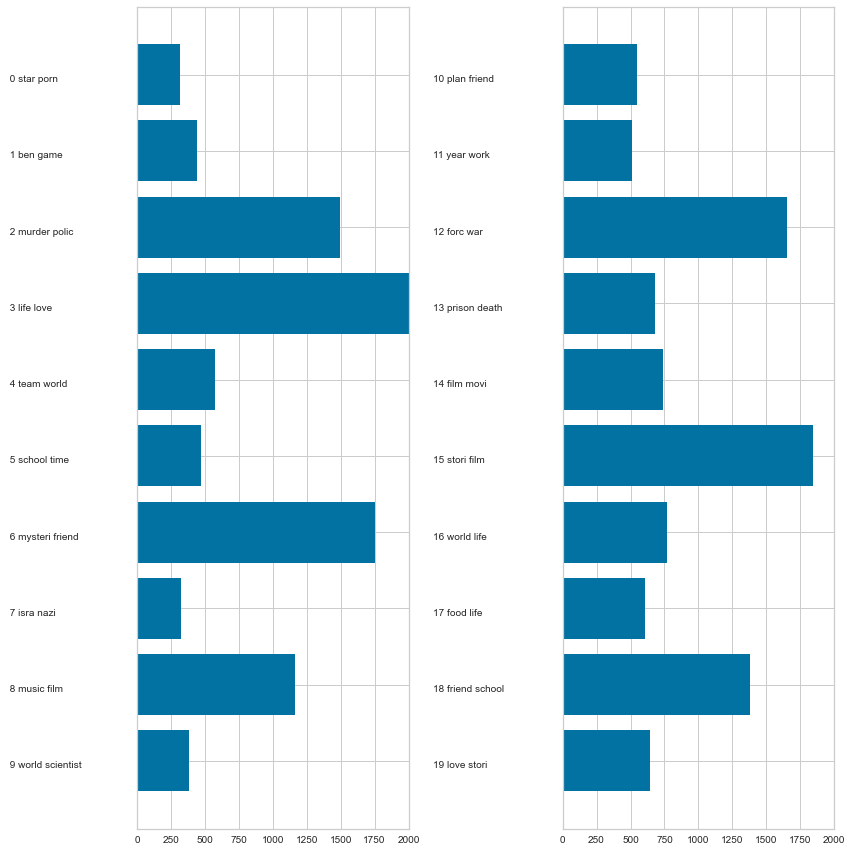

In [55]:
# Let's visualize the result
fig, ax = plt.subplots(1, 2, figsize=(12,12))
# two column bar chart:
for col in [0, 1]: 
    start = col*int(n_topics/2)
    end=(col+1)*int(n_topics/2)
    ax[col].barh(np.arange(int(n_topics/2)), np.sum(document_topics, axis=0)[start:end]) 
    ax[col].set_yticks(np.arange(int(n_topics/2))) 
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top") 
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
    plt.tight_layout()

#### Word Cloud Visualization

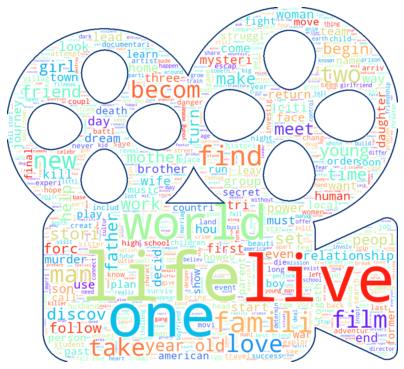

In [56]:

mask = np.array(Image.open("image2.png"))
wordcloud = WordCloud(background_color='white', max_words=1000, mask=mask,contour_color='#023075',contour_width=3,colormap='rainbow').generate(' '.join(main_dataset['story']))
# create image as cloud
plt.figure(figsize = (7,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("WDC.jpg", format="png")
plt.show()

# Modeling data

## Model 1: Logistic Regression

In [35]:
#running Logistic regression with default Class_weight

model1_lr = LogisticRegression()

labels = ['Bag of Words', 'TF-IDF', 'LDA','word embedding']
X_train_group = [X_train_BoW, X_train_TFIDF, X_train_Lda, X_train_WE]
X_test_group = [X_test_BoW, X_test_TFIDF, X_test_Lda, X_test_WE]

y_pred_model1 = []

for i in range(4):
    model1_lr.fit(X_train_group[i], y_train)
    y_pred_model1.append(model1_lr.predict(X_test_group[i]))
    print("Accuracy score for Logistic Regression using",labels[i],": ", accuracy_score(y_test,y_pred_model1[i], normalize=True)*100)

Accuracy score for Logistic Regression using Bag of Words :  69.425
Accuracy score for Logistic Regression using TF-IDF :  69.925
Accuracy score for Logistic Regression using LDA :  57.95
Accuracy score for Logistic Regression using word embedding :  64.75


In [36]:
# Classification report of best model

print('Classification report of Logisitc Regression with default parameters using TF-IDF')
print(classification_report(y_test,y_pred_model1[1]))

Classification report of Logisitc Regression with default parameters using TF-IDF
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      2318
           1       0.67      0.55      0.61      1682

    accuracy                           0.70      4000
   macro avg       0.69      0.68      0.68      4000
weighted avg       0.70      0.70      0.69      4000



#### Logistic Regression with default parameters is performing good. However, we will try to increase its accuracy using different hyper parameters.

In [37]:
# implementing Logistic Regression to account for imbalanced dataset

model_lr = LogisticRegression(max_iter=300, class_weight={1: 0.57, 0: 0.43}) #set class_weight

y_pred_lr = []

for i in range(4):
    model_lr.fit(X_train_group[i], y_train)
    y_pred_lr.append(model_lr.predict(X_test_group[i]))
    print("Accuracy score for Logistic Regression using",labels[i],": ", accuracy_score(y_test,y_pred_lr[i], normalize=True)*100)

Accuracy score for Logistic Regression using Bag of Words :  69.425
Accuracy score for Logistic Regression using TF-IDF :  69.89999999999999
Accuracy score for Logistic Regression using LDA :  53.925
Accuracy score for Logistic Regression using word embedding :  64.0


In [39]:
#classification report of best model

print('Classification report of Logistic Regression using class-weight with TF-IDF')
print(classification_report(y_test,y_pred_lr[1]))

Classification report of Logistic Regression using class-weight with TF-IDF
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      2318
           1       0.63      0.68      0.65      1682

    accuracy                           0.70      4000
   macro avg       0.69      0.70      0.69      4000
weighted avg       0.70      0.70      0.70      4000



#### We can see that Logistic Regression with class weights is performing better than default model. So now, we will try to increase its accuracy using different hyper parameters. Lets use Cross Validation on the model with the highest accuracy score.

In [40]:
params = {'C': [0.001, 0.01, 0.1, 1.0, 10, 100]}

model1_randomsearch = GridSearchCV(estimator = LogisticRegression(max_iter=300, class_weight={1: 0.57, 0: 0.43}),
                           param_grid = params,
                           cv=cv, scoring='accuracy',
                           verbose=2, return_train_score=True)

model1_randomsearch.fit(X_train_TFIDF, y_train)
# Used TF-IDF data as defalut model was performing best 

print("Best parameters for Logistic Regression: ", model1_randomsearch.best_params_)
print("Best Cross-validation score for Logistic Regression: ", model1_randomsearch.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............................................C=0.001; total time=   1.1s
[CV] END ............................................C=0.001; total time=   1.0s
[CV] END ............................................C=0.001; total time=   1.0s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END ..............................................C=0.1; total time=   1.3s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=1.0; total time=   2.4s
[CV] END ..............................................C=1.0; total time=   2.4s
[CV] END ........................................

In [41]:
model1 = model1_randomsearch.best_estimator_

y_pred_model1_htp = model1.predict(X_test_TFIDF)

print("Accuracy score for Logistic Regression with tuned hyper-parameters: ", accuracy_score(y_test,y_pred_model1_htp, normalize=True)*100)

Accuracy score for Logistic Regression with tuned hyper-parameters:  70.325


In [42]:
# classifiaction report for the tuned paramters

print('Logistic Regression accounting with tuned hyperparameters')
print(classification_report(y_test,y_pred_model1_htp))
print('')

Logistic Regression accounting with tuned hyperparameters
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2318
           1       0.64      0.66      0.65      1682

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000




- Logistic Regression Analysis:  Using CV with hyper tuned parameters and accounting for weight classes using the preprocessing TF-IDF method, we find the highest accuracy is 70.32%. 

## Model 2: Multinomial Naive Bayes

In [43]:
# With default hyperparameters

model_nb = MultinomialNB()

y_pred_model2 = []

for i in range(3):
    model_nb.fit(X_train_group[i], y_train)
    y_pred_model2.append(model_nb.predict(X_test_group[i]))
    print("Accuracy score for Multinomial Naive Bayes",labels[i],": ", accuracy_score(y_test, y_pred_model2[i], normalize=True)*100)

Accuracy score for Multinomial Naive Bayes Bag of Words :  68.05
Accuracy score for Multinomial Naive Bayes TF-IDF :  59.75
Accuracy score for Multinomial Naive Bayes LDA :  57.95


In [44]:
print(' Multinomial Naive Bayes Classification Report Using Bag of Words Preprocessing Method')
print(classification_report(y_test,y_pred_model2[0]))
print('')

 Multinomial Naive Bayes Classification Report Using Bag of Words Preprocessing Method
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      2318
           1       0.69      0.44      0.54      1682

    accuracy                           0.68      4000
   macro avg       0.68      0.65      0.65      4000
weighted avg       0.68      0.68      0.66      4000




In [45]:
# Cross validation on the best model of Multinomial Naive Bayes

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}

model2_randomsearch = GridSearchCV(estimator = MultinomialNB(),
                            param_grid = param_grid, cv=cv,
                           scoring='accuracy',
                           return_train_score=True)

model2_randomsearch.fit(X_train_BoW, y_train)
# Used Bag of Words data as defalut model was performing best 

print("Best parameters for Multinomial Naive Bayes: ", model2_randomsearch.best_params_)
print("Best Cross-validation score for Multinomial Naive Bayes: ", model2_randomsearch.best_score_)

Best parameters for Multinomial Naive Bayes:  {'alpha': 1.0}
Best Cross-validation score for Multinomial Naive Bayes:  0.6850001967455174


In [46]:
model2 = model2_randomsearch.best_estimator_

y_pred_model2 = model2.predict(X_test_BoW)

print("Accuracy score for Multinomial Naive Bayes with tuned hyper-parameters: ", accuracy_score(y_test, y_pred_model2, normalize=True)*100)

Accuracy score for Multinomial Naive Bayes with tuned hyper-parameters:  68.05


- Multinomial Naive Bayes Analysis: Highest Accuracy preprocessing method is Bag of Words with an accuracy of 68.05%. Attempting to run CV yielded the same level of accuracy received.

## Model 3: Stochastic Gradient Descent

In [47]:
# With default hyperparameters

model_sgd = SGDClassifier()

y_pred_model3 = []

for i in range(4):
    model_sgd.fit(X_train_group[i], y_train)
    y_pred_model3.append(model_sgd.predict(X_test_group[i]))
    print("Accuracy score for Stochastic Gradient Descent",labels[i],": ", accuracy_score(y_test, y_pred_model3[i], normalize=True)*100)                    

Accuracy score for Stochastic Gradient Descent Bag of Words :  68.22500000000001
Accuracy score for Stochastic Gradient Descent TF-IDF :  69.8
Accuracy score for Stochastic Gradient Descent LDA :  57.95
Accuracy score for Stochastic Gradient Descent word embedding :  64.17500000000001


In [48]:
# SGD using cross validation 

params = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [ 1, 10, 100, 1000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

model3_randomsearch = RandomizedSearchCV(estimator = SGDClassifier(),
                            param_distributions = params,
                           cv=cv, scoring='accuracy',
                           return_train_score=True)

model3_randomsearch.fit(X_train_TFIDF, y_train)
# Used TF-IDF data as defalut model was performing best with TF-IDF preprocessing method 

print("Best parameters for Stochastic Gradient Descent: ", model3_randomsearch.best_params_)
print("Best Cross-validation score for Stochastic Gradient Descent: ", model3_randomsearch.best_score_)

Best parameters for Stochastic Gradient Descent:  {'penalty': 'elasticnet', 'loss': 'hinge', 'learning_rate': 'optimal', 'alpha': 100}
Best Cross-validation score for Stochastic Gradient Descent:  0.5265066130750157


In [49]:
model3 = model3_randomsearch.best_estimator_
y_pred_model3_1 = model3.predict(X_test_TFIDF)

print("Accuracy score for Stochastic Gradient Descent with tuned hyper-parameters: ", accuracy_score(y_test, y_pred_model3_1, normalize=True)*100)

Accuracy score for Stochastic Gradient Descent with tuned hyper-parameters:  42.05


In [50]:
print(' Stochastic Gradient Descent Classification Report Using TF-IDF Preprocessing Method')
print(classification_report(y_test,y_pred_model3[1]))
print('')

 Stochastic Gradient Descent Classification Report Using TF-IDF Preprocessing Method
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2318
           1       0.66      0.57      0.62      1682

    accuracy                           0.70      4000
   macro avg       0.69      0.68      0.68      4000
weighted avg       0.69      0.70      0.69      4000




- Stochastic Gradient Descent Analysis: Preprocessing method with highest accuracy is TF-IDF with 69.8%. Using CV and hypertuned parameters the accuracy dropped to 42.05%

## Model 4: Extreme Gradient Boosting

In [51]:

model_xgb = XGBClassifier() 

y_pred_model4 = []

for i in range(4):
    model_xgb.fit(X_train_group[i], y_train)
    y_pred_model4.append(model_xgb.predict(X_test_group[i]))
    print("Accuracy score for SGDClassifier",labels[i],": ", accuracy_score(y_test,y_pred_model4[i], normalize=True)*100)
    

Accuracy score for SGDClassifier Bag of Words :  66.875
Accuracy score for SGDClassifier TF-IDF :  66.9
Accuracy score for SGDClassifier LDA :  54.85
Accuracy score for SGDClassifier word embedding :  62.775000000000006


In [52]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'n_estimators': [100, 300, 500, 800]}

model4_randomsearch = RandomizedSearchCV(estimator = XGBClassifier(),
                            param_distributions = params,
                           cv=cv,
                           scoring='accuracy',
                            verbose=2,
                           return_train_score=True)

model4_randomsearch.fit(X_train_TFIDF, y_train)
# Used TF-IDF data as defalut model was performing best 

print("Best parameters for EXtreme Gradient Boosting: ", model4_randomsearch.best_params_)
print("Best Cross-validation score for EXtreme Gradient Boosting: ", model4_randomsearch.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=  13.1s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=  19.3s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=  19.4s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=  10.0s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   9.6s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=100; total time=   9.6s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=300; total time=  34.6s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=300; total time=  34.3s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=300; total time=  34.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   9.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   9.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_es

In [53]:
model4 = model4_randomsearch.best_estimator_

y_pred_model4 = model4.predict(X_test_TFIDF)

print("Accuracy score for Extreme Gradient Boosting with tuned hyper-parameters: ", accuracy_score(y_test,y_pred_model4, normalize=True)*100)

Accuracy score for Extreme Gradient Boosting with tuned hyper-parameters:  68.45


In [54]:
print(' Extreme Gradient Boosting Report Using Bag of Words')
print(classification_report(y_test,y_pred_model4))

 Extreme Gradient Boosting Report Using Bag of Words
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      2318
           1       0.64      0.57      0.60      1682

    accuracy                           0.68      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.68      0.68      4000



 - Extreme Gradient Boosting Analysis: Highest Accuracy score 66.9% using TF-IDF method. Best CV using best fitted model of TF-IDF gives us an accuracy score of 68.45%

## Model 5: Random Forest

In [57]:
model5 = RandomForestClassifier()

y_pred_model5 = []

for i in range(4):
    model5.fit(X_train_group[i], y_train)
    y_pred_model5.append(model5.predict(X_test_group[i]))
    print("Accuracy score for Random Forest Classifier",labels[i],": ", accuracy_score(y_test,y_pred_model5[i], normalize=True)*100)

Accuracy score for Random Forest Classifier Bag of Words :  67.05
Accuracy score for Random Forest Classifier TF-IDF :  69.15
Accuracy score for Random Forest Classifier LDA :  55.275
Accuracy score for Random Forest Classifier word embedding :  63.775000000000006


In [59]:
print(' Random Forest Report using TFIDF method')
print(classification_report(y_test,y_pred_model5[1]))

 Random Forest Report using TFIDF method
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2318
           1       0.66      0.55      0.60      1682

    accuracy                           0.69      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.69      0.69      0.69      4000



- Random Forest Analysis: Using TFIDF we have a 69.15% Accuracy with default parameters.

## Model 6: KNN

- Using only bag of words technique as it was giving the best results for above models

In [62]:
model6 = KNeighborsClassifier(n_neighbors=6)

y_pred_model6 = []

for i in range(4):
    model6.fit(X_train_group[i], y_train)
    y_pred_model6.append(model6.predict(X_test_group[i]))
    print("Accuracy score for K Nearest Classifier",labels[i],": ", accuracy_score(y_test,y_pred_model6[i], normalize=True)*100)

Accuracy score for K Nearest Classifier Bag of Words :  57.975
Accuracy score for K Nearest Classifier TF-IDF :  60.75000000000001
Accuracy score for K Nearest Classifier LDA :  56.775
Accuracy score for K Nearest Classifier word embedding :  61.6


In [61]:
print(' KNN Report using Word Embedding method ')
print(classification_report(y_test,y_pred_model6[3]))

 KNN Report using Word Embedding method 
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      2318
           1       0.57      0.34      0.43      1682

    accuracy                           0.62      4000
   macro avg       0.60      0.58      0.57      4000
weighted avg       0.61      0.62      0.59      4000



- KNN Analysis: Using Word Embedding we have an accuracy of 62%.

## Model 7: SVM 

- Using only bag of words technique as it was giving the best results for above models.

In [63]:
# SVM model with default hyperparameters

model7 = SVC()

y_pred_model7 = []

for i in range(4):
    model7.fit(X_train_group[i], y_train)
    y_pred_model7.append(model7.predict(X_test_group[i]))
    print("Accuracy score for SVM Classifier",labels[i],": ", accuracy_score(y_test,y_pred_model7[i], normalize=True)*100)

Accuracy score for SVM Classifier Bag of Words :  70.025
Accuracy score for SVM Classifier TF-IDF :  69.5
Accuracy score for SVM Classifier LDA :  57.95
Accuracy score for SVM Classifier word embedding :  65.2


In [64]:
# SVM using cross validation
params = {'C': [0.01, 0.1, 1.0, 10],
         'gamma': [0.01, 0.1, 1.0],
         'kernel': ['rbf', 'poly', 'sigmoid']}

model7_randomsearch = RandomizedSearchCV(estimator=SVC(), 
                                         param_distributions=params, 
                                        n_iter=10, cv=cv,
                                        scoring='accuracy',
                                         verbose=2, random_state=42)

model7_randomsearch.fit(X_train_BoW, y_train)

print("Best parameters for SVM Classifier: ", model7_randomsearch.best_params_)
print("Best Cross-validation score for SVM Classifier: ", model7_randomsearch.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................C=10, gamma=1.0, kernel=sigmoid; total time= 1.1min
[CV] END ....................C=10, gamma=1.0, kernel=sigmoid; total time= 1.1min
[CV] END ....................C=10, gamma=1.0, kernel=sigmoid; total time= 1.1min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 6.4min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 6.6min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 6.7min
[CV] END ...................C=1.0, gamma=1.0, kernel=sigmoid; total time= 1.1min
[CV] END ...................C=1.0, gamma=1.0, kernel=sigmoid; total time= 1.2min
[CV] END ...................C=1.0, gamma=1.0, kernel=sigmoid; total time= 1.2min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 8.0min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 6.8min
[CV] END ........................C=10, gamma=0.1

In [65]:
model7 = model7_randomsearch.best_estimator_
y_pred_model7 = model7.predict(X_test_BoW)

print("Accuracy score for SVM Classifier with tuned hyperparameters : ", accuracy_score(y_test,y_pred_model7, normalize=True)*100)

Accuracy score for SVM Classifier with tuned hyperparameters :  64.725


In [66]:
print(' SVM Report using Bag of Words method ')
print(classification_report(y_test,y_pred_model7))

 SVM Report using Bag of Words method 
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2318
           1       0.62      0.41      0.50      1682

    accuracy                           0.65      4000
   macro avg       0.64      0.62      0.61      4000
weighted avg       0.64      0.65      0.63      4000



- SVM Analysis: Using Bag of Words we have an accuracy of 64.725%

# Testing Evaluation Data Set

In [67]:
model1.fit(vect_TFIDF.transform(main_dataset.story), y) #fitting complete dataset

LogisticRegression(C=10, class_weight={0: 0.43, 1: 0.57}, max_iter=300)

In [68]:
y_hat = model1.predict(vect_TFIDF.transform(main_dataset.story))
print("Accuracy score for Logistic Regression for complete training dataset: ", accuracy_score(y, y_hat, normalize=True)*100)

Accuracy score for Logistic Regression for complete training dataset:  98.97500000000001


#### Preprocessing evaluation data same as the training data

In [69]:
eval_data = pd.read_csv("movie_story_evaluation_file.csv")
test = pd.merge(eval_data, genre, left_on="movie_id", right_on = "movieId").drop(columns=['movieId', 'title', 'movie_id'])

test.genres[test.genres.str.contains("Drama")] = 1
test.genres[test.genres!=1]=0

for item,text in tqdm(enumerate(test.story)):
    
    text = re.sub(r'\\x[0-9a-f]{2}', "", text)
    text = text.lower()
    text = text.replace("-", " ")
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token.isalpha() and len(token)>2]
    test.story[item] =  " ".join(word for word in tokens)
    

3498it [00:14, 245.64it/s]


In [70]:
test_X = vect_TFIDF.transform(test.story) 

y_pred_model1_test = model1.predict(test_X)
y_pred_test = test.genres.astype('int')

print("Accuracy score for Logistic Regression for evaluation data: ", accuracy_score(y_pred_test,y_pred_model1_test, normalize=True)*100)

Accuracy score for Logistic Regression for evaluation data:  71.66952544311035


## Oversampling technique 

In [71]:
import joblib

In [72]:
X_TFIDF = vect_TFIDF.transform(main_dataset.story)

In [75]:
# import library
import joblib
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_ros, y_ros = ros.fit_resample(X_TFIDF, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 11588, 1: 8412})
Resample dataset shape Counter({0: 11588, 1: 11588})


In [76]:
X_ros.shape, y_ros.shape

((23176, 385238), (23176,))

In [77]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, 
                                                    test_size=0.2, random_state=0, stratify=y_ros)

#### Training and evaluating the logistic regression model(best model) with default hyperparameters

In [86]:
lr = LogisticRegression() 

lr.fit(X_train_ros, y_train_ros)
y_pred_ros = lr.predict(X_test_ros)
print("Accuracy score for Logistic Regression default model: ", accuracy_score(y_test_ros,y_pred_ros, normalize=True)*100)

Accuracy score for Logistic Regression default model:  72.04486626402071


In [87]:
# classifiaction report for the tuned paramters

print('Classification report of logistic regression model')
print('')
print(classification_report(y_test_ros,y_pred_ros))
print('')

Classification report of logistic regression model

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      2318
           1       0.70      0.77      0.73      2318

    accuracy                           0.72      4636
   macro avg       0.72      0.72      0.72      4636
weighted avg       0.72      0.72      0.72      4636




In [88]:
lr.fit(X_ros, y_ros) #fitting complete dataset
y_ros_lr = lr.predict(X_ros)

print("Accuracy score for Logistic Regression for complete dataset(in-sample): ", accuracy_score(y_ros, y_ros_lr, normalize=True)*100)

Accuracy score for Logistic Regression for complete dataset(in-sample):  91.37038315498792


In [89]:
y_eval_lr = lr.predict(test_X)
print("Accuracy score for Logistic Regression for evaluation data(out-of-sample): ", accuracy_score(y_pred_test,y_eval_lr, normalize=True)*100)

Accuracy score for Logistic Regression for evaluation data(out-of-sample):  72.15551743853631


#### Logistic regression with hyperparameter

In [81]:
params = {'C': [0.001, 0.01, 0.1, 1.0,10,100]}

model1_ros = GridSearchCV(estimator = LogisticRegression(max_iter=300),
                           param_grid = params,
                           cv=cv, scoring='accuracy',
                           verbose=2, return_train_score=True)

model1_ros.fit(X_train_ros, y_train_ros)

print("Best parameters for Logistic Regression: ", model1_ros.best_params_)
print("Best Cross-validation score for Logistic Regression: ", model1_ros.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............................................C=0.001; total time=   2.3s
[CV] END ............................................C=0.001; total time=   2.2s
[CV] END ............................................C=0.001; total time=   2.2s
[CV] END .............................................C=0.01; total time=   2.2s
[CV] END .............................................C=0.01; total time=   2.3s
[CV] END .............................................C=0.01; total time=   2.3s
[CV] END ..............................................C=0.1; total time=   3.6s
[CV] END ..............................................C=0.1; total time=   3.6s
[CV] END ..............................................C=0.1; total time=   3.4s
[CV] END ..............................................C=1.0; total time=   7.7s
[CV] END ..............................................C=1.0; total time=   6.8s
[CV] END ........................................

In [82]:
model_ros = model1_ros.best_estimator_
y_pred_model1_ros = model_ros.predict(X_test_ros)

print("Accuracy score for Logistic Regression with tuned hyper-parameters: ", accuracy_score(y_test_ros,y_pred_model1_ros, normalize=True)*100)

Accuracy score for Logistic Regression with tuned hyper-parameters:  74.87057808455565


In [83]:
# classifiaction report for the tuned paramters

print('Logistic Regression accounting with tuned hyper-parameters and oversampling')
print('')
print(classification_report(y_test_ros,y_pred_model1_ros))
print('')

Logistic Regression accounting with tuned hyper-parameters and oversampling

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2318
           1       0.72      0.81      0.76      2318

    accuracy                           0.75      4636
   macro avg       0.75      0.75      0.75      4636
weighted avg       0.75      0.75      0.75      4636




In [84]:
#fitting complete dataset
model_ros.fit(X_ros, y_ros) 
y_ros_all = model_ros.predict(X_ros)
print("Accuracy score for Logistic Regression for complete dataset(in-sample): ", accuracy_score(y_ros, y_ros_all, normalize=True)*100)

Accuracy score for Logistic Regression for complete dataset(in-sample):  99.8619261304798


In [85]:
#predict the eval data based on fitted model for whole data
y_eval = model_ros.predict(test_X)

print("Accuracy score for Logistic Regression for evaluation data(out-of-sample): ", accuracy_score(y_pred_test,y_eval, normalize=True)*100)

Accuracy score for Logistic Regression for evaluation data(out-of-sample):  70.7833047455689


# Conclusion:

In Conclusion, using TF-IDF and random oversampling technique as the pre-processing methods we received a 72.16% accuracy score for the evaluation data.